### Libraries

In [1]:
# Utils
import pandas as pd
import numpy as np
import json
import os
import subprocess
import zipfile
import IPython.display as ipd
from pathlib import Path
from collections import Counter

# Library for audio processing
import librosa
import soundfile as sf

# Library for silence removal
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Library for noise reduction
import noisereduce as nr

# Visualizations and plots
import matplotlib.pyplot as plt

# Options
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Warnings
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )

c:\Users\Dinesh\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Example

In [2]:
# Load an example track
audio_path = 'public_dataset/public_dataset/00291cce-36a0-4a29-9e2d-c1d96ca17242.wav'
original_track, original_sr = librosa.load(audio_path)
ipd.Audio(original_track, rate = original_sr)

In [3]:
# Apply noise reduction
reduced_noise = nr.reduce_noise(y=original_track, sr=original_sr)
sf.write('public_dataset/Example/noiseremoval_example.wav', reduced_noise, 22050) # Saving the audio track
ipd.Audio(reduced_noise, rate = original_sr)

In [4]:
# Reading and splitting the audio file into chunks
sound = AudioSegment.from_file('public_dataset/Example/noiseremoval_example.wav', format = "wav") 
audio_chunks = split_on_silence(sound,
                                min_silence_len = 1000, # Remove silence longer than 1s
                                silence_thresh = -45,   # What is below -45 dB is considered silence
                                keep_silence = 500)     # Keep 0.5s of silence at the beginning/end

# Putting the file back together
combined = AudioSegment.empty()
for chunk in audio_chunks:
    combined += chunk

# Save the final audio file
combined.export(f'public_dataset/Example/silenceremoval_example.wav', format = "wav")

<_io.BufferedRandom name='public_dataset/Example/silenceremoval_example.wav'>

In [5]:
# Loading track after silence removal
nosilence_track, nosilence_sr = librosa.load('public_dataset/Example/silenceremoval_example.wav')
ipd.Audio(nosilence_track, rate = nosilence_sr)

In [6]:
nosilence_track, nosilence_sr = librosa.load('public_dataset/Example/silenceremoval_example.wav')
std_audio = librosa.util.fix_length(nosilence_track, size=132300)
sf.write('public_dataset/Example/audiopreprocessed_example.wav', std_audio, 22050) # Saving the audio track
ipd.Audio(std_audio, rate = nosilence_sr)

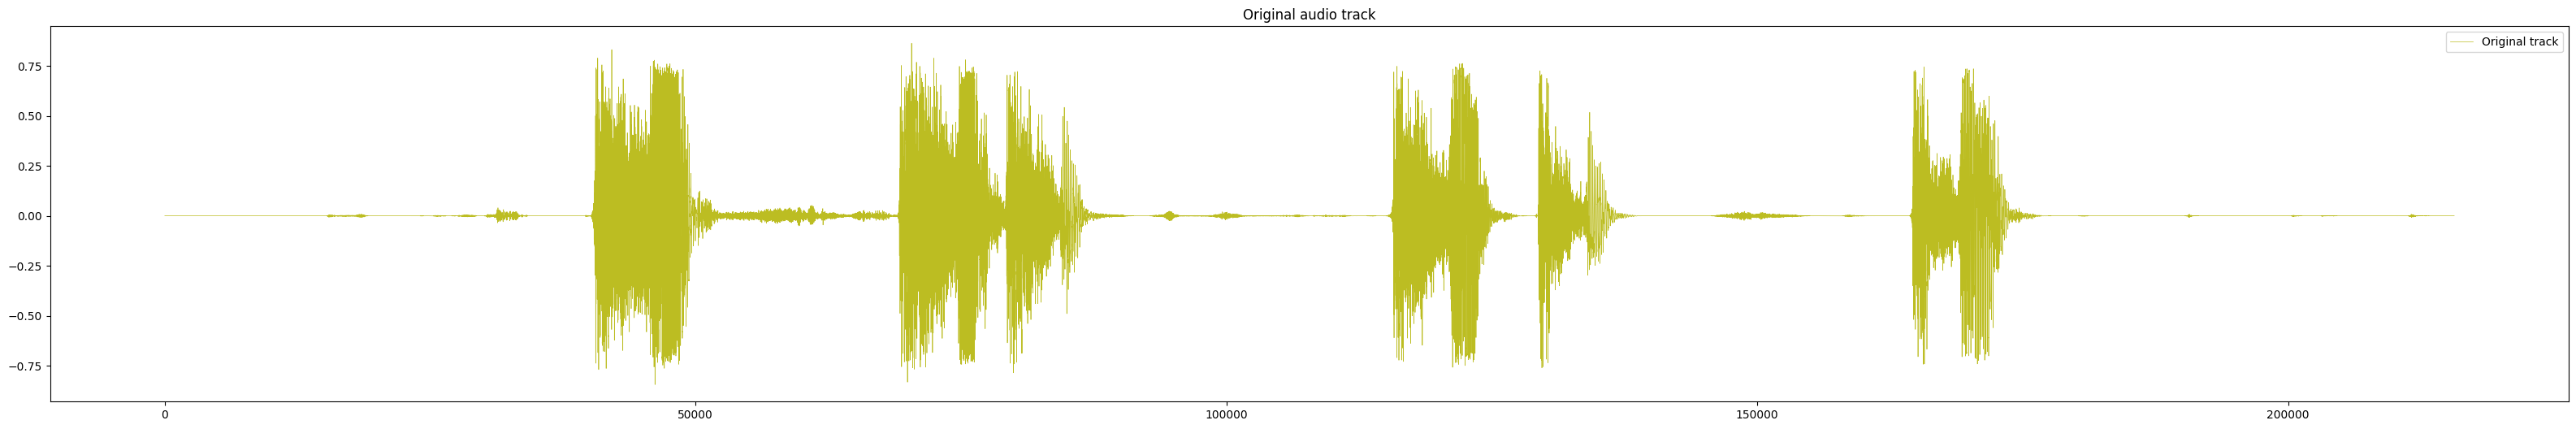

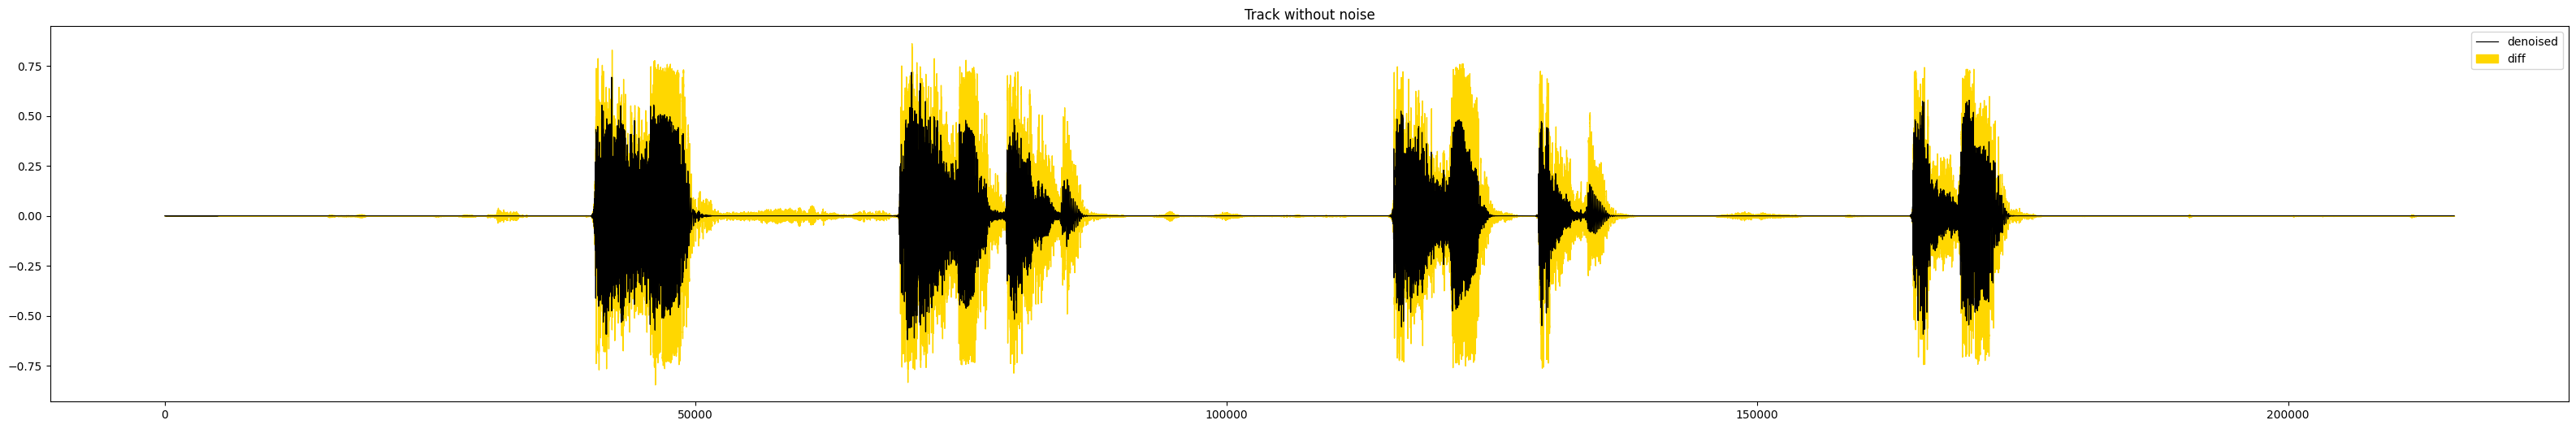

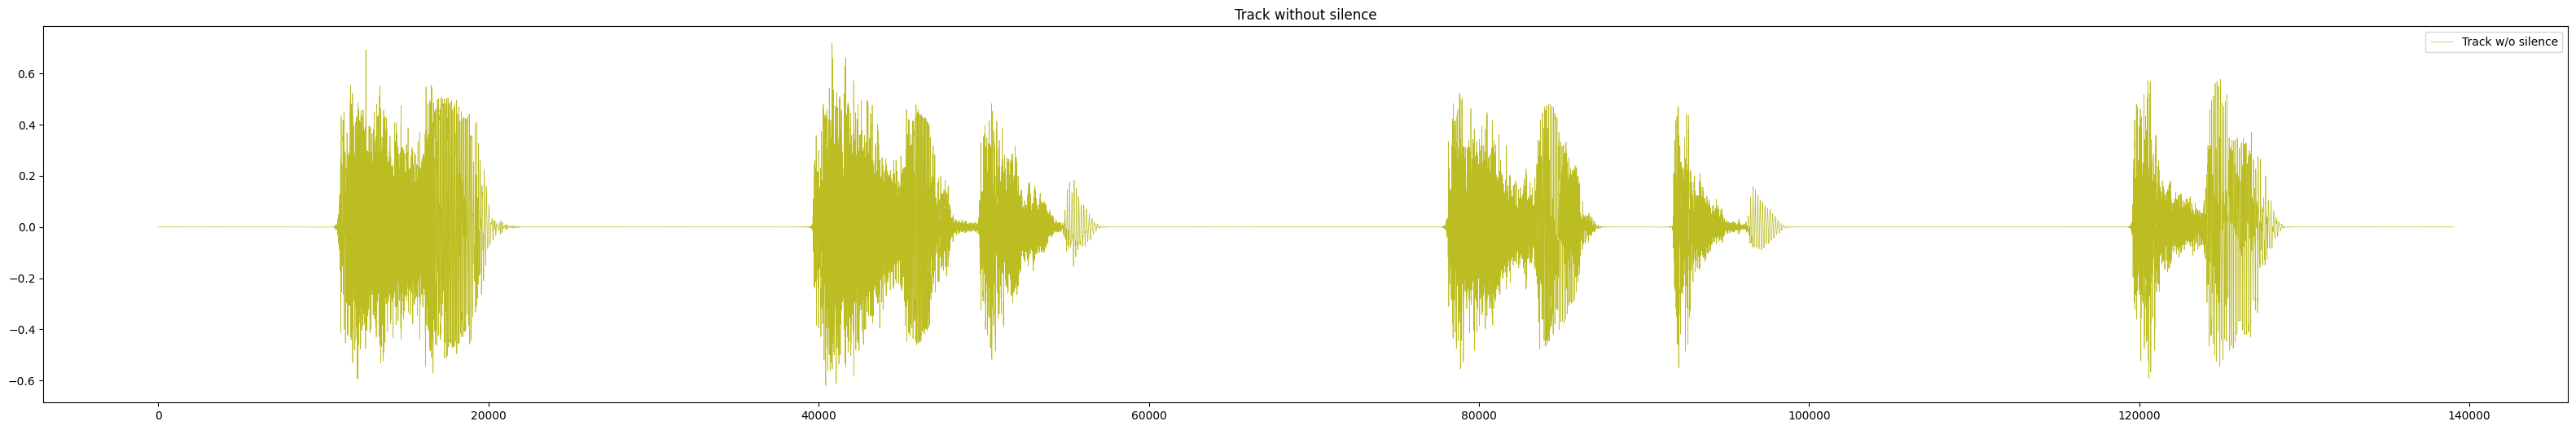

In [7]:
plt.figure(figsize=(40,6))
plt.plot(original_track, color='tab:olive', linewidth=0.5, label = 'Original track')
# plt.hlines(0, 0, 5000,color='black', linewidth=0.7)
plt.title("Original audio track")
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(reduced_noise, color='black', linewidth=0.9, label = 'denoised')
plt.fill_between(np.arange(0, 215649, 1), original_track, reduced_noise, color='gold', label = 'diff')
plt.hlines(0, 0, 5000, color='black', linewidth=0.4)
plt.title("Track without noise")
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(nosilence_track, color='tab:olive', linewidth=0.5, label = 'Track w/o silence')
# plt.hlines(0, 0, 5000, color='black', linewidth=0.7)
plt.title("Track without silence")
plt.legend()
plt.show()

### De-noising

In [8]:
def noise_remover(inputdir, audio_writedir):
  counter = 0
  for audio in os.listdir(inputdir):
    if audio.endswith(".wav"):
      tmp_readpath = os.path.join(inputdir, audio)
      tmp_audio, tmp_sr = librosa.load(tmp_readpath)
      reduced_noise = nr.reduce_noise(y=tmp_audio, sr=tmp_sr)
      tmp_writepath = os.path.join(audio_writedir, audio)
      sf.write(tmp_writepath, reduced_noise, 22050)                   # Save audio file

      counter += 1
      if counter%1000 == 0:
        print('Done: ' + str(counter))

In [9]:
inputdir = 'public_dataset/public_dataset'
outputdir = 'public_dataset/AudioNoNoise'

In [10]:
noise_remover(inputdir, outputdir)

c:\Users\Dinesh\anaconda3\lib\site-packages\noisereduce\noisereduce.py:306: RuntimeWarning: invalid value encountered in true_divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


Done: 1000
Done: 2000
Done: 3000
Done: 4000
Done: 5000
Done: 6000
Done: 7000
Done: 8000
Done: 9000
Done: 10000
Done: 11000
Done: 12000
Done: 13000
Done: 14000
Done: 15000
Done: 16000
Done: 17000
Done: 18000
Done: 19000
Done: 20000


### Silence removal

In [11]:
# Load dataframe for this part
cough_tracks = pd.read_csv('public_dataset/public_dataset/metadata_coughtracks.csv')
cough_tracks = cough_tracks.drop(['Unnamed: 0'], axis = 1)
cough_tracks.head()

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,0.9609,15.0,male,False,False,healthy
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0.9301,34.0,male,True,False,healthy
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0.9968,21.0,male,False,False,healthy
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,0.8937,28.0,female,False,False,healthy
4,00291cce-36a0-4a29-9e2d-c1d96ca17242,0.9883,15.0,male,False,False,healthy


In [12]:
# Definition of the list of files and the path where they are saved
all_uuids = cough_tracks['uuid'].values
wavaudio_datadir = 'public_dataset/public_dataset/'

In [13]:
def silence_remover(file_path, file_name, audio_format):
  sound = AudioSegment.from_file(file_path, format = audio_format)  # Load the audiotrack with correct audio format
  audio_chunks = split_on_silence(sound,                            # Splits the audio track based on silence
                                min_silence_len = 1000,             # Remove silence longer than 1s
                                silence_thresh = -45,               # What is below -45 dB is considered silence
                                keep_silence = 500)                 # Keep 0.5s of silence at the beginning/end
  
  combined = AudioSegment.empty()
  for chunk in audio_chunks:  # Putting the file back together
    combined += chunk
  savename = file_name+'.wav'


  # Save the processed file
  combined.export(f'public_dataset/AudioNoSilence/{savename}', format = 'wav')

In [14]:
skipped_uuids = []
checklist = [10, 100, 1000, 10000]
counter = 0

# For each file in our dataset, we check its extension so that we can import it correctly. 
# If a file is not processed correctly, we save its name in an external list
for uuid in all_uuids:
  counter += 1
  if counter in checklist:
    print('Processed ' + str(counter) + ' tracks')
#   # try to look for a .webm file  
#   tmp_audiofilename = webmaudio_datadir+uuid+".webm"
#   if not os.path.exists(tmp_audiofilename):
#     # try to look for a .ogg file
#     tmp_audiofilename = oggaudio_datadir+uuid+".ogg"
    if not os.path.exists(tmp_audiofilename):
      # try to look for a .wav file
      tmp_audiofilename = wavaudio_datadir+uuid+".wav"
      if not os.path.exists(tmp_audiofilename):
        print("WARNING! Could not find audio file for UUID: {}  . Skipping.".format(uuid))
        continue

  tmp_audiofilename = wavaudio_datadir+uuid+".wav"
  file_path = tmp_audiofilename
  file_name = uuid

  audio_format = tmp_audiofilename.split('.')[-1]
  try:
    silence_remover(file_path=file_path, file_name=file_name, audio_format=audio_format)
  except:
    skipped_uuids.append(uuid)
    with open("public_dataset/JSON_Utils/skipped_in_silenceremoval.json", "w") as fp:
      json.dump(skipped_uuids, fp)

Processed 10 tracks
Processed 100 tracks
Processed 1000 tracks


In [15]:
#Saving skipped uuids

with open("public_dataset/JSON_Utils/skipped_in_silenceremoval.json", "w") as fp:
  json.dump(skipped_uuids, fp)

In [16]:
with open('public_dataset/JSON_Utils/skipped_in_silenceremoval.json', 'rb') as fp:
  skipped_uuids = json.load(fp)

In [18]:
path = 'public_dataset/AudioNoSilence'
print('Audio after silence removal: ' + str(len(os.listdir(path))))
print('Audio skipped in silence removal: ' + str(len(skipped_uuids)))

Audio after silence removal: 6879
Audio skipped in silence removal: 0


### Organizing metadata

In [19]:
# Removing rows corresponding to skipped uuids
new_metadata = cough_tracks[~cough_tracks['uuid'].isin(skipped_uuids)]
new_metadata.shape

(6879, 7)

In [20]:
# Having converted all the files to .wav format, we can add the extension to the uuids
new_metadata['uuid'] = new_metadata['uuid'].astype(str) + '.wav'

# cough_detected is no longer useful
new_metadata = new_metadata.drop(['cough_detected'], axis = 1)

new_metadata.reset_index(inplace=True, drop=True)
new_metadata.head()

,uuid,age,gender,respiratory_condition,fever_muscle_pain,status
0,00039425-7f3a-42aa-ac13-834aaa2b6b92.wav,15.0,male,False,False,healthy
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav,34.0,male,True,False,healthy
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav,21.0,male,False,False,healthy
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav,28.0,female,False,False,healthy
4,00291cce-36a0-4a29-9e2d-c1d96ca17242.wav,15.0,male,False,False,healthy


The classification problem we want to address is a binary classification problem: positive for COVID19 vs. negative for COVID19. So, the crucial point concerns how to handle audio tracks labeled as *symptomatic* (to be emphasized that these are NEGATIVE symptomatic). Some papers suggest putting them in the positive class, since in a real case it is less severe to have false positives rather than false negatives, but for our goal we want to be able to distinguish between positive and negative for COVID. Therefore, since symptomatic individuals are not labeled as positive, we decide to place them in the negative class.

In [21]:
# COVID_BI_1 --> symptomatic as positive class (in case we want to use it)
new_metadata = new_metadata.assign(COVID19_BI_1=np.where(new_metadata['status'] == 'healthy', 'Unlikely', 'Likely'))

# COVID_BI_1 --> symptomatic as negative class
new_metadata = new_metadata.assign(COVID19_BI_2=np.where(new_metadata['status'] == 'COVID-19', 'Positive', 'Negative'))

In [22]:
new_metadata.head()

,uuid,age,gender,respiratory_condition,fever_muscle_pain,status,COVID19_BI_1,COVID19_BI_2
0,00039425-7f3a-42aa-ac13-834aaa2b6b92.wav,15.0,male,False,False,healthy,Unlikely,Negative
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav,34.0,male,True,False,healthy,Unlikely,Negative
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav,21.0,male,False,False,healthy,Unlikely,Negative
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav,28.0,female,False,False,healthy,Unlikely,Negative
4,00291cce-36a0-4a29-9e2d-c1d96ca17242.wav,15.0,male,False,False,healthy,Unlikely,Negative


In [23]:
new_metadata.groupby('COVID19_BI_1').size()

COVID19_BI_1
Likely      1570
Unlikely    5309
dtype: int64

In [24]:
new_metadata.groupby('COVID19_BI_2').size()

COVID19_BI_2
Negative    6411
Positive     468
dtype: int64

In [25]:
with open('public_dataset/public_dataset/metadata_nosilence.csv', 'w', encoding = 'utf-8-sig') as f:
  new_metadata.to_csv(f)

### Resizing audio tracks

In [26]:
# Load dataframe for this part
audiotracks = pd.read_csv('public_dataset/public_dataset/metadata_nosilence.csv')
audiotracks = audiotracks.drop(['Unnamed: 0'], axis = 1)

#### Checking audio tracks lenght

In [27]:
all_uuids = audiotracks['uuid'].values
audio_datadir = 'public_dataset/AudioNoSilence/'

In [28]:
def import_raw_audio(filename, indir, sr=None):
    t, sr = librosa.load(indir+filename, sr=sr, mono=True)
    return t, sr

In [29]:
audio_duration = []
sampling_rates = []
j = 0

for uuid in all_uuids:
  tmp_audio, sr = import_raw_audio(uuid, indir=audio_datadir)
  duration = tmp_audio.shape[0]/sr
  sampling_rates.append(sr)
  audio_duration.append(duration)
  if j%1000 == 0:
    print('Done '+str(j)+' iterations')
  j=j+1

Done 0 iterations
Done 1000 iterations
Done 2000 iterations
Done 3000 iterations
Done 4000 iterations
Done 5000 iterations
Done 6000 iterations


In [30]:
# Saving audio durations and sampling rates

with open('public_dataset/JSON_Utils/audio_durations.json', "w") as fp:
  json.dump(audio_duration, fp)

with open('public_dataset/JSON_Utils/sampling_rates.json', "w") as fp:
  json.dump(sampling_rates, fp)

In [31]:
# Loading audio durations and sampling rates

with open('public_dataset/JSON_Utils/audio_durations.json', 'rb') as fp:
  audio_duration = json.load(fp)

with open('public_dataset/JSON_Utils/sampling_rates.json', "rb") as fp:
  sampling_rates = json.load(fp)

In [32]:
print(len(audio_duration))
print(len(sampling_rates))

6879
6879


In [33]:
sr_results = Counter(sampling_rates)
print(sr_results)

Counter({48000: 6865, 1: 14})


Len < 2: 797
Len < 3: 1964
Len < 4: 3262
Len < 5: 4420
Len < 6: 5348
Len < 7: 6016
Len < 8: 6485
Len < 9: 6754


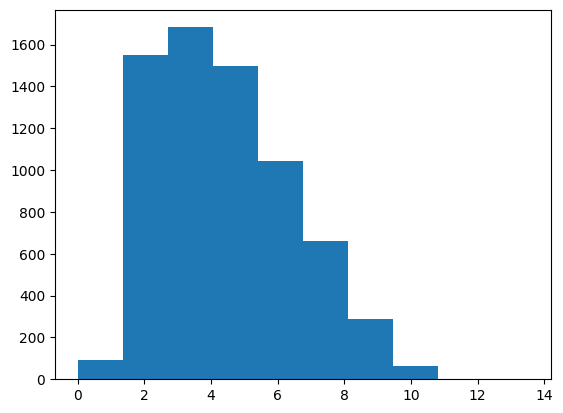

In [34]:
plt.hist(audio_duration);

print('Len < 2: ' + str(sum([i < 2 for i in audio_duration])))
print('Len < 3: ' + str(sum([i < 3 for i in audio_duration])))
print('Len < 4: ' + str(sum([i < 4 for i in audio_duration])))
print('Len < 5: ' + str(sum([i < 5 for i in audio_duration])))
print('Len < 6: ' + str(sum([i < 6 for i in audio_duration])))
print('Len < 7: ' + str(sum([i < 7 for i in audio_duration])))
print('Len < 8: ' + str(sum([i < 8 for i in audio_duration])))
print('Len < 9: ' + str(sum([i < 9 for i in audio_duration])))

In [35]:
# Example of a long audio track

long_path = 'public_dataset/AudioNoSilence/db044a11-1d57-4365-8364-1f73f5fb1bdf.wav'
long_track, long_sr = librosa.load(long_path)
ipd.Audio(long_track, rate = long_sr)

### Resizing all audio tracks

In [36]:
all_uuids = audiotracks['uuid'].values
audio_datadir = 'public_dataset/AudioNoSilence/'
audio_writedir = 'public_dataset/AudioPreprocessedComplete/'

In [37]:
def standardize_lenght(filelist, audio_datadir, audio_writedir, lenght, skip_list):
  counter = 0
  for uuid in filelist:
    tmp_path = audio_datadir+uuid
    tmp_writepath = audio_writedir+uuid

    try:
      tmp_audio, tmp_sr = librosa.load(tmp_path)                  # By default loads audio at a 22050Hz
      tmp_audio = librosa.util.fix_length(tmp_audio, size=lenght) # Fix desired length
      sf.write(tmp_writepath, tmp_audio, 22050)                   # Save audio file
    except:
      skip_list.append(uuid)

    counter += 1
    if counter%1000 == 0:
      print('Done: ' + str(counter) + '/' + str(len(filelist)))

In [38]:
skipped_in_std = [] # Skipped uuids in length standardization

standardize_lenght(all_uuids, audio_datadir, audio_writedir, 132300, skipped_in_std) # 132300 = 6 seconds

Done: 1000/6879
Done: 2000/6879
Done: 3000/6879
Done: 4000/6879
Done: 5000/6879
Done: 6000/6879


In [39]:
with open('public_dataset/JSON_Utils/skipped_in_standardization.json', "w") as fp:
  json.dump(skipped_in_std, fp)

In [40]:
# Loading skipped_in_std

with open('public_dataset/JSON_Utils/skipped_in_standardization.json', 'rb') as fp:
  skipped_in_std = json.load(fp)

In [41]:
len(skipped_in_std)

14

The skipped audio in the standardization are those with a sampling rate of 1, which can't be converted to 22050Hz.

### Re-organizing metadata

In [42]:
metadata_final = audiotracks[~audiotracks['uuid'].isin(skipped_in_std)]
metadata_final.reset_index(inplace=True, drop=True)
print(metadata_final.shape)

(6865, 8)


In [43]:
with open('public_dataset/metadata[FINAL].csv', 'w',
          encoding = 'utf-8-sig') as f:
          metadata_final.to_csv(f)